This notebook is for questions 2

(2) Forecast of monthly sales volumes by product category


In [ ]:
%pip install pymysql

import matplotlib.pyplot as plt
import os
import pymysql
import pandas as pd
import numpy as np

succeess = False

while not succeess:
  try:
    conn = pymysql.connect(
        host='db-aff.cpapv35x7rsh.us-east-2.rds.amazonaws.com',
        port=int(3306),
        user="admin",
        passwd="ds5110db",
        db='olist',
        charset='utf8mb4')
    db = conn.cursor()
    succeess = True
  except:
    print("Wrong Password")

print("Connection Made")


def add_quotes(s):
  return '"'+str(s)+'",'

def add_quotes_nocomma(s):
  return '"'+str(s)+'"'

     |████████████████████████████████| 43 kB 823 kB/s 
Connection Made


In [ ]:
# Importing the required libraries
import pandas as pd
pd.set_option('display.max_columns', 50) # Display up to 50 columns at a time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
plt.style.use('seaborn')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,5
import glob # To read all csv files in the directory
import seaborn as sns
import calendar

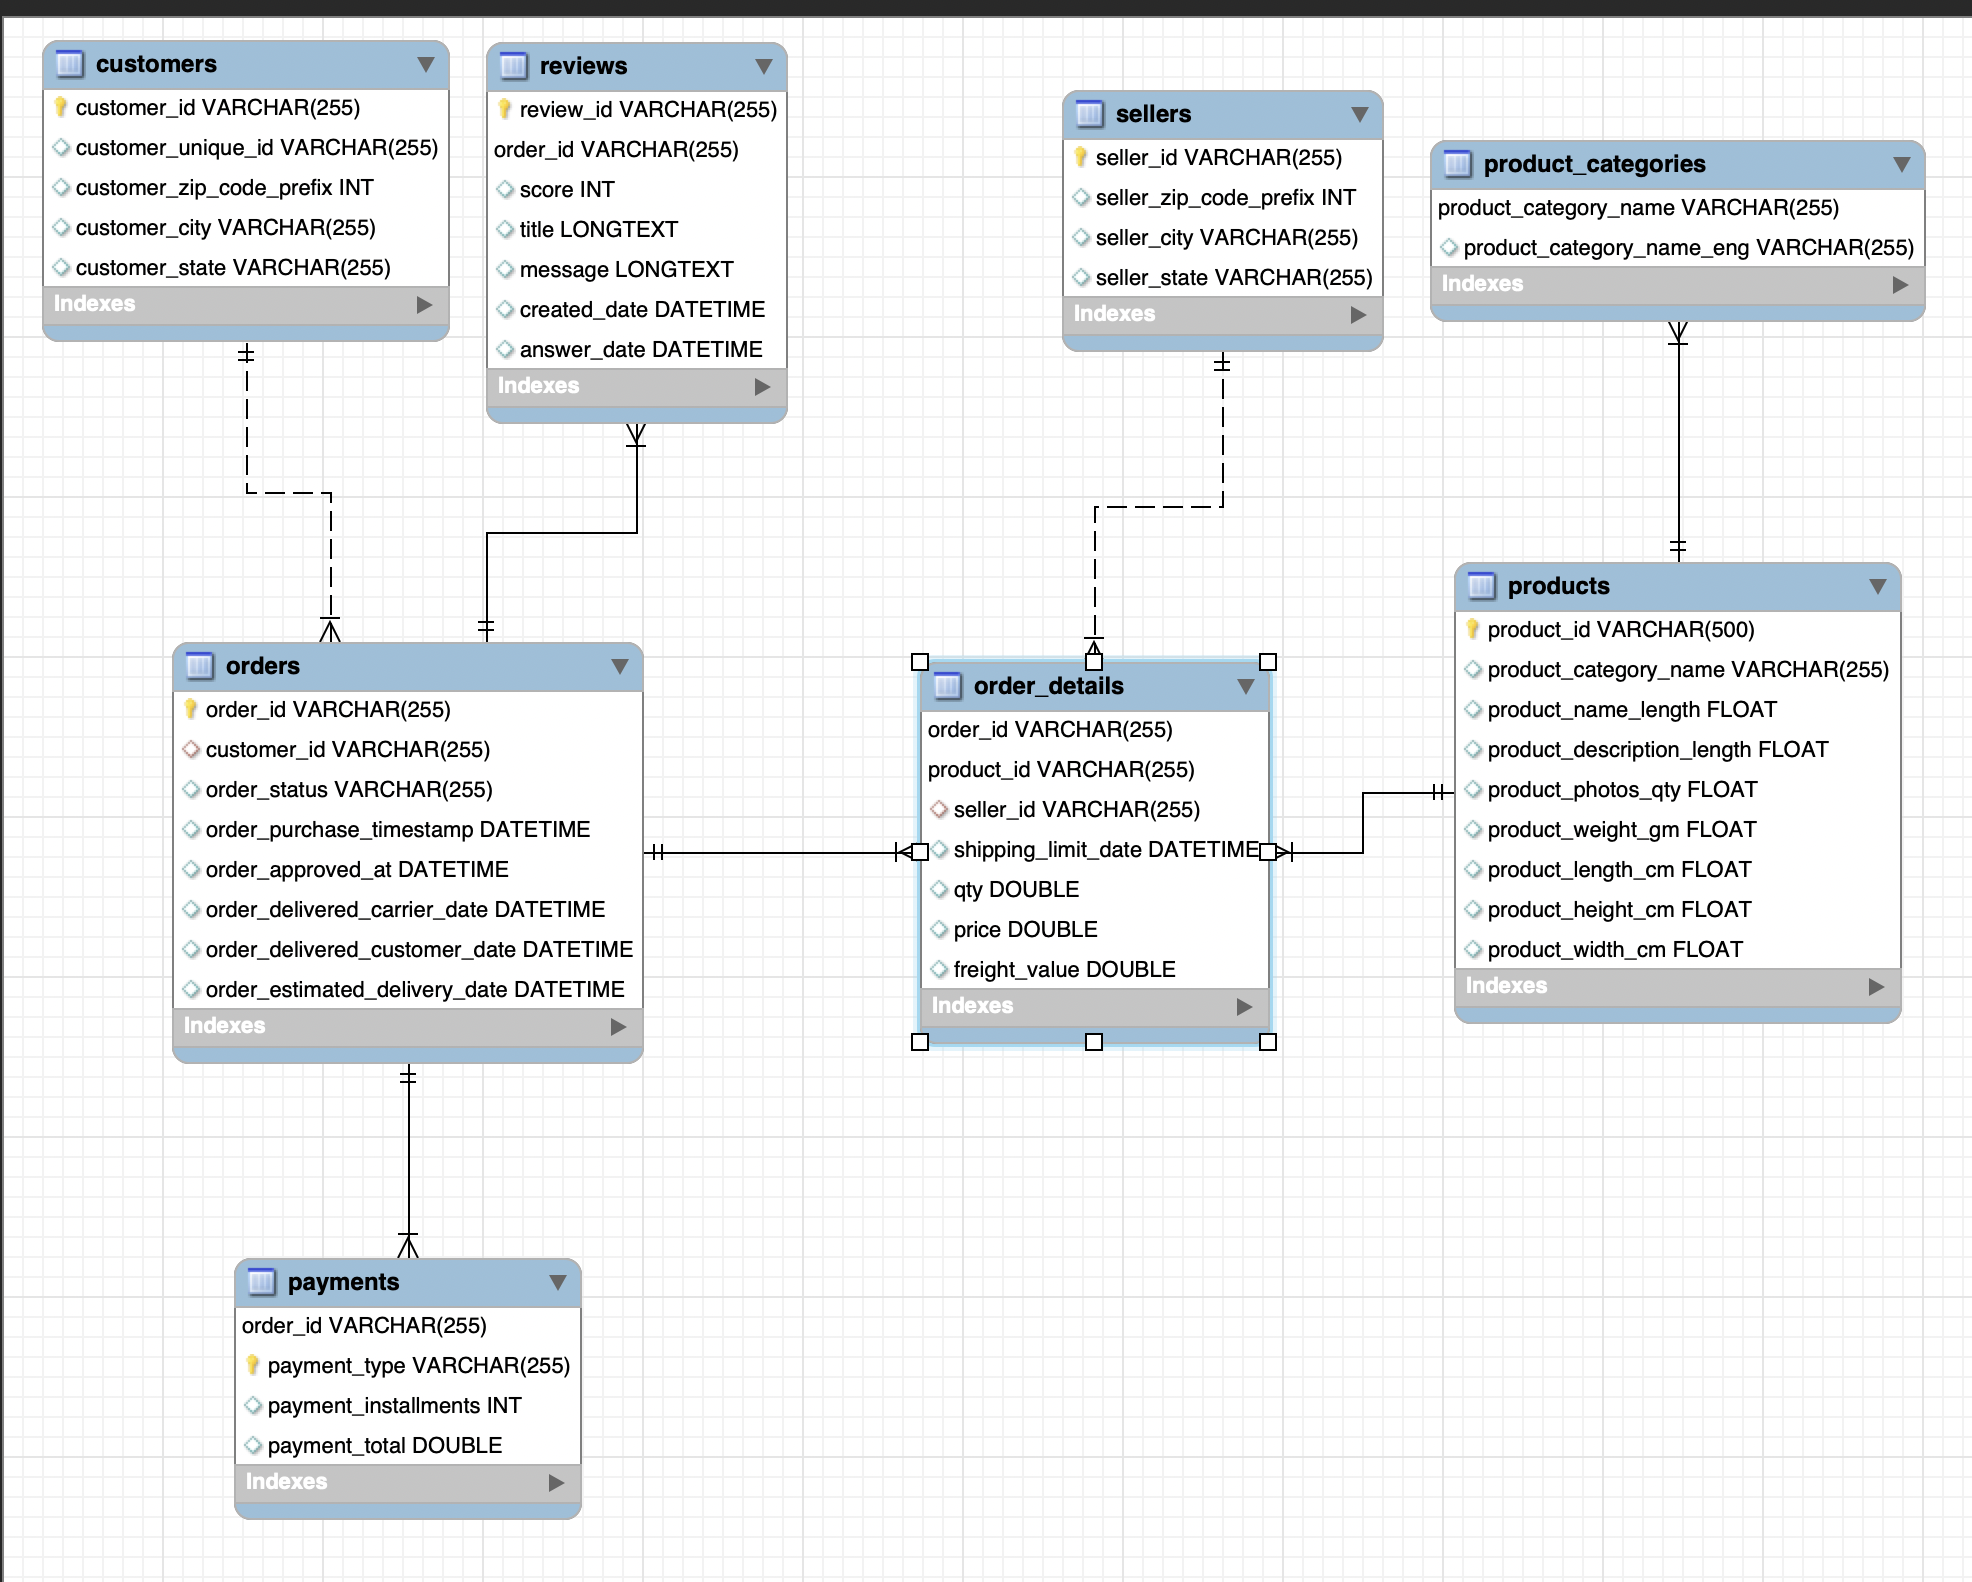

In [ ]:
#(string query, connection from the first code block above)
products = pd.read_sql_query("SELECT * from olist.products", conn)
payments = pd.read_sql_query("SELECT * from olist.payments", conn)
orders = pd.read_sql_query("SELECT * from olist.orders", conn)
order_details = pd.read_sql_query("SELECT * from olist.order_details", conn)
customers = pd.read_sql_query("SELECT * from olist.customers", conn)
reviews = pd.read_sql_query("SELECT * from olist.reviews", conn)
sellers = pd.read_sql_query("SELECT * from olist.sellers", conn)
product_categories = pd.read_sql_query("SELECT * from olist.product_categories", conn)

In [ ]:
products.info()
orders.info()
order_details.info()
product_categories.info()
payments.info()
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32951 non-null  object 
 2   product_name_length         32951 non-null  float64
 3   product_description_length  32951 non-null  float64
 4   product_photos_qty          32951 non-null  float64
 5   product_weight_gm           32951 non-null  float64
 6   product_length_cm           32951 non-null  float64
 7   product_height_cm           32951 non-null  float64
 8   product_width_cm            32951 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --

In [ ]:
order_details.order_id.nunique()

98666

In [ ]:
reviews.order_id.nunique()

98673

There are orders in 'orders' table that are not in 'order details' table. Hence left join by 'order details' table so that we have info on price, freight, etc. on each order.

In [ ]:
#left join orders and order_details, there is no NA
all_orders = pd.merge(order_details, orders, on='order_id',how='left')
len(all_orders)
#all[all.isnull().any(axis=1)]
#same order_id can have multiple different product_ids

102425

In [ ]:
#From the payments table, calculate total payments per order id. However, for sales prediction we will not use this but use total price+freight to calculate sales values
payment_group = payments.groupby(['order_id'])['payment_total'].sum().reset_index()
payment_group.head(5)

,order_id,payment_total
0,00010242fe8c5a6d1ba2dd792cb16214,72.19
1,00018f77f2f0320c557190d7a144bdd3,259.83
2,000229ec398224ef6ca0657da4fc703e,216.87
3,00024acbcdf0a6daa1e931b038114c75,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04


In [ ]:
#Join the product table with the category translation table so we have English names of the order categories
product_complete = pd.merge(products, product_categories, on='product_category_name', how = 'left')
#product_complete.product_category_name_eng.unique()

In [ ]:
#Some product categories are available in portuguese but not english. We translate those manually here. There are NULL values for categories still.
product_complete.loc[product_complete['product_category_name']=='pc_gamer', 'product_category_name_eng'] = 'pc_gamer'
product_complete.loc[product_complete['product_category_name']=='portateis_cozinha_e_preparadores_de_alimentos', 'product_category_name_eng'] = 'kitchen_dining_laundry_garden_furniture'
product_complete[product_complete.isnull().any(axis=1)].product_category_name.unique()

array(['nan'], dtype=object)

In [ ]:
#Join the order details table with product category table
sales = pd.merge(all_orders, product_complete[['product_id', 'product_category_name_eng', 'product_photos_qty', 'product_description_length', 'product_name_length']], on='product_id',how='left')
#there is one order with order details but no payment info.
#check for null values in the dataset. null values are all in the product category column 
#sales[sales.isnull().any(axis=1)]

In [ ]:
#Calulate and insert a total_price columns:
sales['total_price'] = sales.apply(lambda row: row.qty*(row.price + row.freight_value), axis=1)
#check orders that have >1 products to make sure total price was calculated correctly
#sales[sales['qty']>1]

In [ ]:
#Check total payments and total prices, there are 255 rows where payment is different from total price. The amount is insignificant so we will leave them there (do not remove them)
#sales[['order_id', 'total_price','payment_total']]
#sales = sales.groupby(['order_id','payment_total'])['total_price'].sum().reset_index()
#sales['diff_pay'] = sales.apply(lambda row: round((row.payment_total-row.total_price),0), axis=1)
#diff=sales[sales['diff_pay']!=0]
#diff.sort_values(by='diff_pay', ascending=False)

I want to calculate sale volumes per category per month. Will be using orders, order_items, and products dataset. 


In [ ]:
#total sale values (sum total_price) by category
sales_val = sales.groupby(['product_category_name_eng'])['total_price'].sum().reset_index()
sales_val.sort_values('total_price', ascending=False)

,product_category_name_eng,total_price
43,health_beauty,1441248.07
71,watches_gifts,1305541.61
7,bed_bath_table,1241681.72
66,sports_leisure,1156656.48
15,computers_accessories,1059272.40
...,...,...
35,flowers,1598.91
46,home_comfort_2,1170.58
11,cds_dvds_musicals,954.99
29,fashion_childrens_clothes,665.36


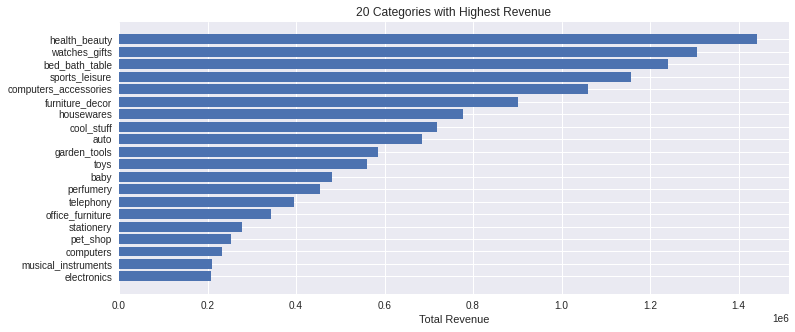

In [ ]:
sales_val20 = sales_val.sort_values('total_price', ascending=False).head(20).iloc[::-1]
plt.barh(sales_val20.product_category_name_eng, sales_val20.total_price)
plt.title('20 Categories with Highest Revenue')
plt.xlabel('Total Revenue')
plt.show()

In [ ]:
#total sales volumes (count of products) by categories, 
sales_vol= sales.groupby(['product_category_name_eng'])['qty'].sum().reset_index()
sales_vol.sort_values(by='qty',ascending=False)

,product_category_name_eng,qty
7,bed_bath_table,11115.0
43,health_beauty,9670.0
66,sports_leisure,8641.0
39,furniture_decor,8334.0
15,computers_accessories,7827.0
...,...,...
11,cds_dvds_musicals,14.0
52,la_cuisine,14.0
59,pc_gamer,9.0
29,fashion_childrens_clothes,8.0


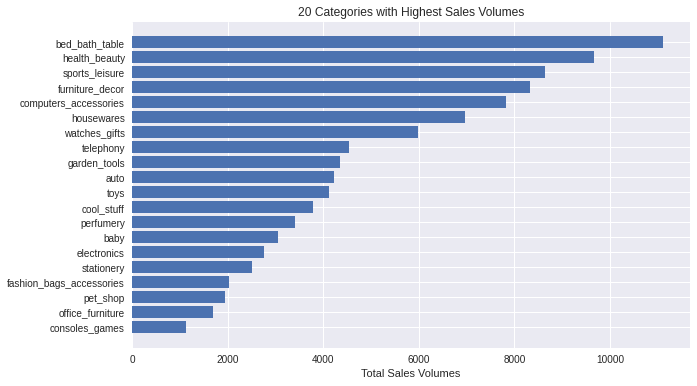

In [ ]:
sales_vol20 = sales_vol.sort_values('qty', ascending=False).head(20).iloc[::-1]
plt.figure(figsize=(10,6))
plt.barh(sales_vol20.product_category_name_eng, sales_vol20.qty)
plt.title('20 Categories with Highest Sales Volumes')
plt.xlabel('Total Sales Volumes')
plt.show()

Now we will investigate trend and seasonality of sale volumes by month, weekday, hour?


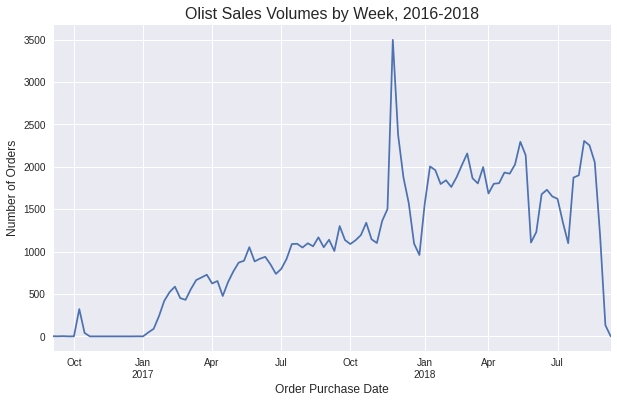

In [ ]:
#trend and seasonality
#line graph of total sale volumes by month of time purchase
#tsdf2 <- master_df  %>% filter(product_category_name_english %in% top80sales$product_category_name_english) %>% 
#            group_by(order_purchase_timestamp) %>% 
#                summarise(sales_volume = sum(qty))


plt.figure(figsize=(10,6))
sales.set_index('order_purchase_timestamp').qty.resample('W').sum().plot()
plt.xlabel('Order Purchase Date', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.title('Olist Sales Volumes by Week, 2016-2018', fontsize=16)
plt.show()

#want to plot holidays on here but don't know how

In [ ]:
#from google.colab import file
#uploaded = files.upload()
#import io
#holidays = pd.read_csv(io.BytesIO(uploaded['brazil_holidays.csv']))
#holidays['Date'] =  pd.to_datetime(holidays['Date'])

In [ ]:
plt.figure(figsize=(10,6))
sales_health = sales[sales['product_category_name_eng']=='health_beauty']
#sales_health.set_index('order_purchase_timestamp').qty.resample('W').sum().plot()
#plt.xlabel('Order Purchase Date', fontsize=12)
#plt.ylabel('Number of Orders', fontsize=12)
#plt.title('Sales Volumes of Health_Beauty Products by Week, 2016-2018', fontsize=16)
#plt.show()


<Figure size 720x432 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,6))
sales_health = sales[sales['product_category_name_eng']=='bed_bath_table']
#sales_health.set_index('order_purchase_timestamp').qty.resample('W').sum().plot()
#plt.xlabel('Order Purchase Date', fontsize=12)
#plt.ylabel('Number of Orders', fontsize=12)
#plt.title('Sales Volumes of Bed_Bath_Table Products by Week, 2016-2018', fontsize=16)
#plt.show()


<Figure size 720x432 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,6))
sales_health = sales[sales['product_category_name_eng']=='sports_leisure']
#sales_health.set_index('order_purchase_timestamp').qty.resample('W').sum().plot()
#plt.xlabel('Order Purchase Date', fontsize=12)
#plt.ylabel('Number of Orders', fontsize=12)
#plt.title('Sales Volumes of Sports_Leisure Products by Week, 2016-2018', fontsize=16)
#plt.show()


<Figure size 720x432 with 0 Axes>

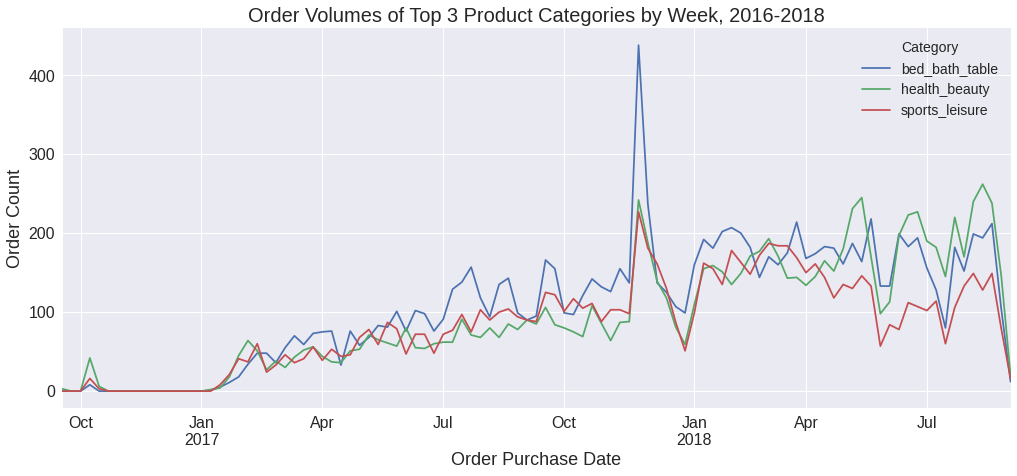

In [ ]:
#sales by top 3 best selling categories
import matplotlib.dates as mdates
sales_cat3 = sales[sales['product_category_name_eng'].isin(["bed_bath_table", "health_beauty", "sports_leisure"])]
sales_cat3 = sales_cat3.groupby(['order_purchase_timestamp','product_category_name_eng']).sum()['qty'].unstack()
sales_cat3.resample('W').sum().plot(figsize = (17,7), legend=True)
plt.xlabel('Order Purchase Date', fontsize=18)
plt.ylabel('Order Count', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Order Volumes of Top 3 Product Categories by Week, 2016-2018', fontsize=20)
plt.legend(title="Category", title_fontsize=14, fontsize=14, fancybox=True)
plt.show()

In [ ]:
#Average sales per day of week
sales.head(10)


,order_id,product_id,seller_id,shipping_limit_date,qty,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_category_name_eng,product_photos_qty,product_description_length,product_name_length,total_price
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,1.0,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,cool_stuff,4.0,598.0,58.0,72.19
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,1.0,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,pet_shop,2.0,239.0,56.0,259.83
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,1.0,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,furniture_decor,2.0,695.0,59.0,216.87
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,1.0,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,perfumery,1.0,480.0,42.0,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,1.0,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,garden_tools,1.0,409.0,59.0,218.04
5,00048cc3ae777c65dbb7d2a0634bc1ea,ef92defde845ab8450f9d70c526ef70f,6426d21aca402a131fc0a5d0960a3c90,2017-05-23 03:55:27,1.0,21.90,12.69,816cbea969fe5b689b39cfc97a506742,delivered,2017-05-15 21:42:34,2017-05-17 03:55:27,2017-05-17 11:05:55,2017-05-22 13:44:35,2017-06-06,housewares,1.0,558.0,36.0,34.59
6,00054e8431b9d7675808bcb819fb4a32,8d4f2bb7e93e6710a28f34fa83ee7d28,7040e82f899a04d1b434b795a43b4617,2017-12-14 12:10:31,1.0,19.90,11.85,32e2e6ab09e778d99bf2e0ecd4898718,delivered,2017-12-10 11:53:48,2017-12-10 12:10:31,2017-12-12 01:07:48,2017-12-18 22:03:38,2018-01-04,telephony,1.0,815.0,52.0,31.75
7,000576fe39319847cbb9d288c5617fa6,557d850972a7d6f792fd18ae1400d9b6,5996cddab893a4652a15592fb58ab8db,2018-07-10 12:30:45,1.0,810.00,70.75,9ed5e522dd9dd85b4af4a077526d8117,delivered,2018-07-04 12:08:27,2018-07-05 16:35:48,2018-07-05 12:15:00,2018-07-09 14:04:07,2018-07-25,garden_tools,3.0,1310.0,39.0,880.75
8,0005a1a1728c9d785b8e2b08b904576c,310ae3c140ff94b03219ad0adc3c778f,a416b6a846a11724393025641d4edd5e,2018-03-26 18:31:29,1.0,145.95,11.65,16150771dfd4776261284213b89c304e,delivered,2018-03-19 18:40:33,2018-03-20 18:35:21,2018-03-28 00:37:42,2018-03-29 18:17:31,2018-03-29,health_beauty,1.0,493.0,59.0,157.60
9,0005f50442cb953dcd1d21e1fb923495,4535b0e1091c278dfd193e5a1d63b39f,ba143b05f0110f0dc71ad71b4466ce92,2018-07-06 14:10:56,1.0,53.99,11.40,351d3cb2cee3c7fd0af6616c82df21d3,delivered,2018-07-02 13:59:39,2018-07-02 14:10:56,2018-07-03 14:25:00,2018-07-04 17:28:31,2018-07-23,books_technical,1.0,1192.0,52.0,65.39


In [ ]:
print("Dataset contains orders made from", sales['order_purchase_timestamp'].min().strftime("%d %B, %Y"), "to", sales['order_purchase_timestamp'].max().strftime("%d %B, %Y"))

Dataset contains orders made from 04 September, 2016 to 03 September, 2018


In [ ]:
sales['buy_day']=sales['order_purchase_timestamp'].dt.day_name()
sales['buy_month']=sales['order_purchase_timestamp'].dt.month_name()
sales['buy_hour'] = sales['order_purchase_timestamp'].dt.hour # Extracting hour from deadline
sales['buy_year'] = sales['order_purchase_timestamp'].dt.year
sales.buy_year.unique()
sales.groupby('buy_year').size()

buy_year
2016      332
2017    46314
2018    55779
dtype: int64

In [ ]:
#sales_time = sales.groupby(['order_purchase_timestamp']).sum()['qty'].reset_index()

sales_time=sales.groupby(['buy_month', 'buy_year']).sum()['qty'].reset_index()

sales_2017=sales_time[sales_time['buy_year']==2017]
sales_2017['buy_month'] = pd.Categorical(sales_2017['buy_month'], ['January','February','March','April','May','June','July','August','September','October','November','December'])
sales_2017=sales_2017.sort_values('buy_month')
sales_2017

sales_2018=sales_time[sales_time['buy_year']==2018]
sales_2018['buy_month'] = pd.Categorical(sales_2018['buy_month'], ['January','February','March','April','May','June','July','August','September'])
sales_2018=sales_2018.sort_values('buy_month')
sales_2018

sales_1718=sales[(sales['order_purchase_timestamp'] >= '2017-09-01') &(sales['order_purchase_timestamp'] < '2018-09-01')]
sales_1718=sales_1718.groupby(['buy_month', 'buy_year']).sum()['qty'].reset_index()  

sales_1718['buy_month'] = pd.Categorical(sales_1718['buy_month'], ['January','February','March','April','May','June','July','August','September','October','November','December'])
sales_1718=sales_1718.sort_values('buy_month')
sales_1718

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,buy_month,buy_year,qty
4,January,2018,8208.0
3,February,2018,7672.0
7,March,2018,8217.0
0,April,2018,7975.0
8,May,2018,7925.0
6,June,2018,7078.0
5,July,2018,7092.0
1,August,2018,7248.0
11,September,2017,4831.0
10,October,2017,5322.0


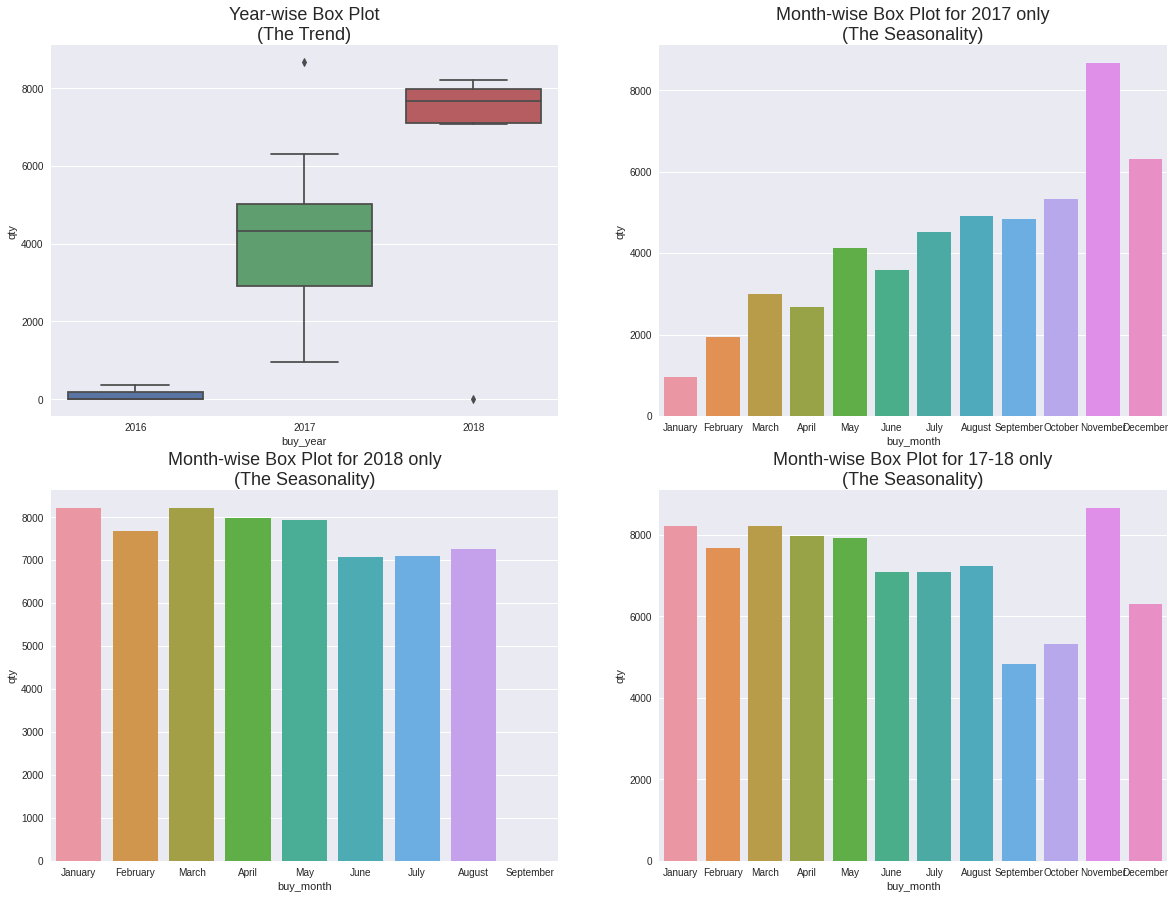

In [ ]:

# Draw Plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,15))
sns.boxplot(x='buy_year', y='qty', data=sales_time, ax=ax1)
sns.barplot(x='buy_month', y='qty', data=sales_2017, ax=ax2)
sns.barplot(x='buy_month', y='qty', data=sales_2018, ax=ax3)
sns.barplot(x='buy_month', y='qty', data=sales_1718, ax=ax4)

# Set Title
ax1.set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
ax2.set_title('Month-wise Box Plot for 2017 only\n(The Seasonality)', fontsize=18)
ax3.set_title('Month-wise Box Plot for 2018 only\n(The Seasonality)', fontsize=18)
ax4.set_title('Month-wise Box Plot for 17-18 only\n(The Seasonality)', fontsize=18)
plt.show()




The boxplots make the year-wise and month-wise distributions evident. Also, in a month-wise boxplot, the months of winter has higher drug sales, which can be attributed to the holiday discounts season. 2018 seasonality is different from 2017 pattern tho


# Forecasting for Overall to Compare Models
Training/Testing Split = I will use the last 4 months data (April 2018-July 2018) as a testing set, while the remaining previous data will be used to train the forecasting models.

In order to use time series forecasting, we need to make sure the time series data is stationary. A stationary series is one where the values of the series is not a function of time. That is, the statistical properties of the series like mean, variance and autocorrelation are constant over time.

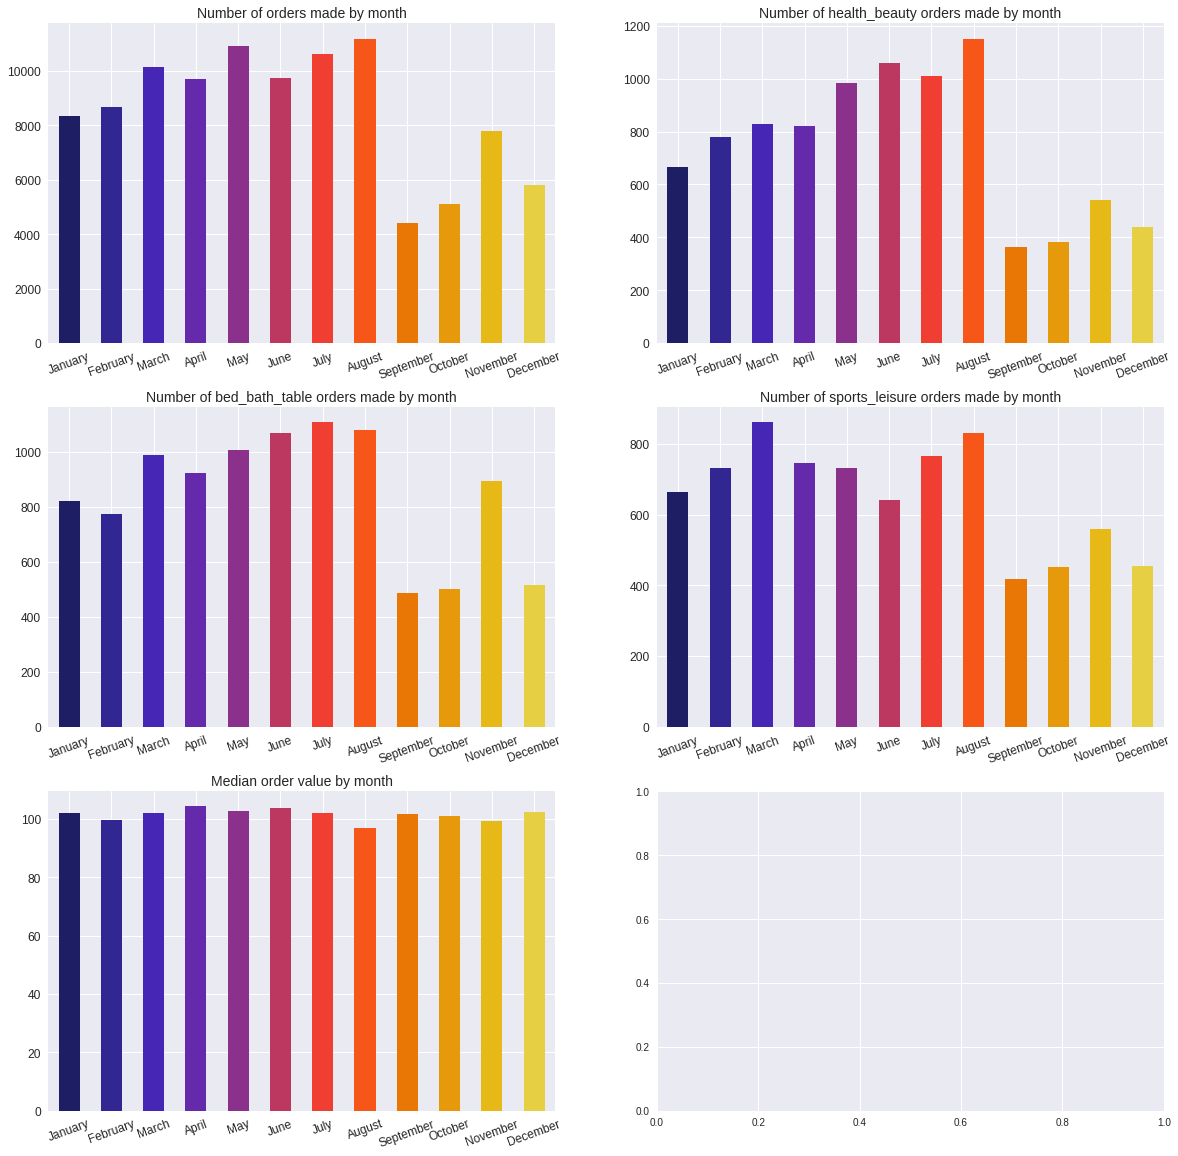

In [ ]:
# Plotting
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20,20))

color1 = cm.CMRmap(np.linspace(0.1,0.8,sales.buy_month.nunique())) # Setting a colormap
months = ['January','February','March','April','May','June','July','August','September','October','November','December']

#data set is from 09/2016 to 09/2018 so average 2 years 
sales['buy_month'].value_counts().reindex(months).plot(kind='bar',color=color1, rot=20, ax=ax1)
ax1.set_title('Number of orders made by month', fontsize=14)
ax1.set_ylabel('', fontsize=12)
ax1.set_xlabel('')
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)


#average sales value made by month for each category
sales_health = sales[sales['product_category_name_eng']=='health_beauty']
sales_health['buy_month'].value_counts().reindex(months).plot(kind='bar',color=color1, rot=20, ax=ax2)
ax2.set_title('Number of health_beauty orders made by month', fontsize=14)
ax2.set_ylabel('', fontsize=12)
ax2.set_xlabel('')
ax2.xaxis.set_tick_params(labelsize=12)
ax2.yaxis.set_tick_params(labelsize=12)

sales_bed = sales[sales['product_category_name_eng']=='bed_bath_table']
sales_bed['buy_month'].value_counts().reindex(months).plot(kind='bar',color=color1, rot=20, ax=ax3)
ax3.set_title('Number of bed_bath_table orders made by month', fontsize=14)
ax3.set_ylabel('', fontsize=12)
ax3.set_xlabel('')
ax3.xaxis.set_tick_params(labelsize=12)
ax3.yaxis.set_tick_params(labelsize=12)

sales_sports = sales[sales['product_category_name_eng']=='sports_leisure']
sales_sports['buy_month'].value_counts().reindex(months).plot(kind='bar',color=color1, rot=20, ax=ax4)
ax4.set_title('Number of sports_leisure orders made by month', fontsize=14)
ax4.set_ylabel('', fontsize=12)
ax4.set_xlabel('')
ax4.xaxis.set_tick_params(labelsize=12)
ax4.yaxis.set_tick_params(labelsize=12)

#median amount of total_price each month:
sales.groupby('buy_month').total_price.median().reindex(months).plot(kind='bar', color=color1, rot=20, ax=ax5)
ax5.set_title('Median order value by month', fontsize=14)
ax5.set_ylabel('', fontsize=12)
ax5.set_xlabel('')
ax5.xaxis.set_tick_params(labelsize=12)
ax5.yaxis.set_tick_params(labelsize=12)


Monthly trend of sale volumes of top 3 categories is pretty similar to the overall trend - higest sales in the summar months, and lowest in the fall/ winter

In [ ]:
len(sales_health)

9022

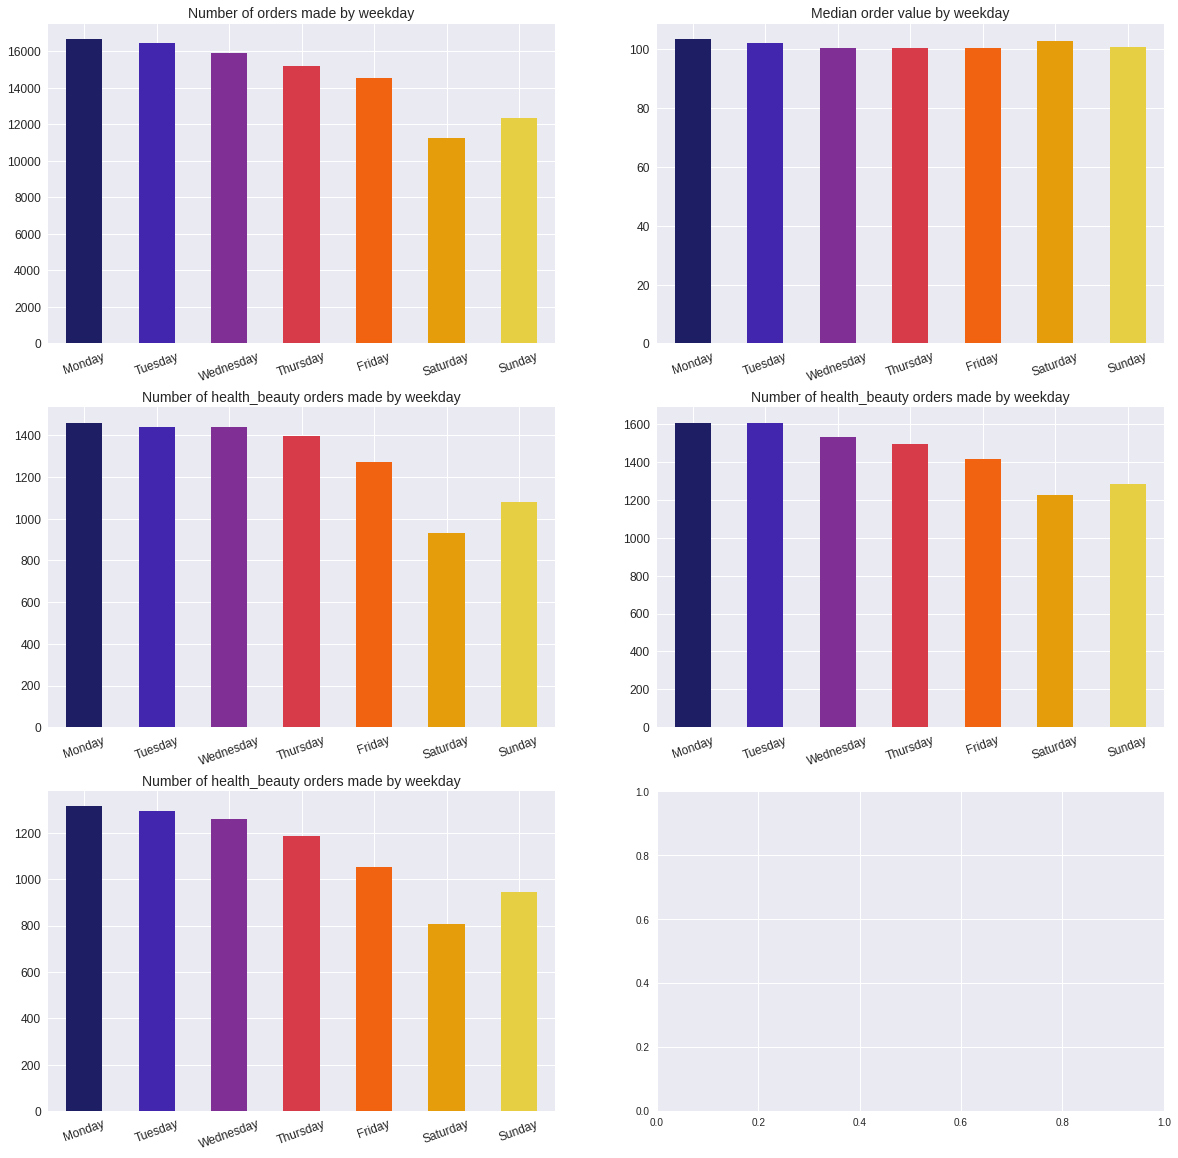

In [ ]:
# Plotting
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20,20))

color2 = cm.CMRmap(np.linspace(0.1,0.8,sales.buy_day.nunique())) # Setting a colormap
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

#data set is from 09/2016 to 09/2018 so average 2 years 
sales['buy_day'].value_counts().reindex(weekdays).plot(kind='bar',color=color2, rot=20, ax=ax1)
ax1.set_title('Number of orders made by weekday', fontsize=14)
ax1.set_ylabel('', fontsize=12)
ax1.set_xlabel('')
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)

#median amount of total_price each day of week:
sales.groupby('buy_day').total_price.median().reindex(weekdays).plot(kind='bar', color=color2, rot=20, ax=ax2)
ax2.set_title('Median order value by weekday', fontsize=14)
ax2.set_ylabel('', fontsize=12)
ax2.set_xlabel('')
ax2.xaxis.set_tick_params(labelsize=12)
ax2.yaxis.set_tick_params(labelsize=12)



#average sales value made by month for each category
sales_health['buy_day'].value_counts().reindex(weekdays).plot(kind='bar',color=color2, rot=20, ax=ax3)
ax3.set_title('Number of health_beauty orders made by weekday', fontsize=14)
ax3.set_ylabel('', fontsize=12)
ax3.set_xlabel('')
ax3.xaxis.set_tick_params(labelsize=12)
ax3.yaxis.set_tick_params(labelsize=12)

#average sales value made by month for each category
sales_bed['buy_day'].value_counts().reindex(weekdays).plot(kind='bar',color=color2, rot=20, ax=ax4)
ax4.set_title('Number of health_beauty orders made by weekday', fontsize=14)
ax4.set_ylabel('', fontsize=12)
ax4.set_xlabel('')
ax4.xaxis.set_tick_params(labelsize=12)
ax4.yaxis.set_tick_params(labelsize=12)

#average sales value made by month for each category
sales_sports['buy_day'].value_counts().reindex(weekdays).plot(kind='bar',color=color2, rot=20, ax=ax5)
ax5.set_title('Number of health_beauty orders made by weekday', fontsize=14)
ax5.set_ylabel('', fontsize=12)
ax5.set_xlabel('')
ax5.xaxis.set_tick_params(labelsize=12)
ax5.yaxis.set_tick_params(labelsize=12)



Weekly trend seems to be the same by category as overall. Mondays sell the most while saturdays sell the least.

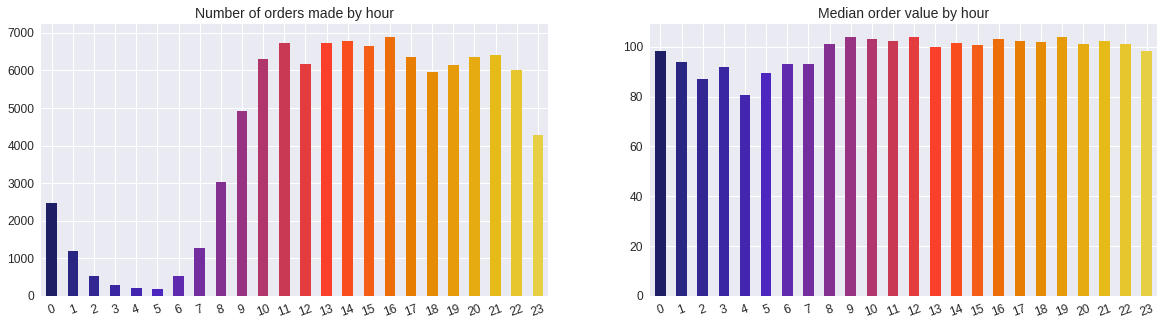

In [ ]:

# Plotting
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20,5))

color3 = cm.CMRmap(np.linspace(0.1,0.8,sales.buy_hour.nunique())) # Setting a colormap
hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

#data set is from 09/2016 to 09/2018 so average 2 years 
sales['buy_hour'].value_counts().reindex(hours).plot(kind='bar',color=color3, rot=20, ax=ax1)
ax1.set_title('Number of orders made by hour', fontsize=14)
ax1.set_ylabel('', fontsize=12)
ax1.set_xlabel('')
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)

#median amount of total_price by hour of the day
sales.groupby('buy_hour').total_price.median().reindex(hours).plot(kind='bar', color=color3, rot=20, ax=ax2)
ax2.set_title('Median order value by hour', fontsize=14)
ax2.set_ylabel('', fontsize=12)
ax2.set_xlabel('')
ax2.xaxis.set_tick_params(labelsize=12)
ax2.yaxis.set_tick_params(labelsize=12)


In [ ]:
#Average sales per hour of day


## This section looks at review scores and other features



In [ ]:
sales.head(5)

,order_id,product_id,seller_id,shipping_limit_date,qty,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_category_name_eng,product_photos_qty,product_description_length,product_name_length,total_price,buy_day,buy_month,buy_hour,buy_year
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,1.0,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,cool_stuff,4.0,598.0,58.0,72.19,Wednesday,September,8,2017
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,1.0,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,pet_shop,2.0,239.0,56.0,259.83,Wednesday,April,10,2017
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,1.0,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,furniture_decor,2.0,695.0,59.0,216.87,Sunday,January,14,2018
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,1.0,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,perfumery,1.0,480.0,42.0,25.78,Wednesday,August,10,2018
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,1.0,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,garden_tools,1.0,409.0,59.0,218.04,Saturday,February,13,2017


In [ ]:
reviews.info()
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   review_id     99224 non-null  object        
 1   order_id      99224 non-null  object        
 2   score         99224 non-null  int64         
 3   title         99224 non-null  object        
 4   message       99224 non-null  object        
 5   created_date  99224 non-null  datetime64[ns]
 6   answer_date   99224 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 5.3+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 102425 entries, 0 to 102424
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       102425 non-null  object        
 1   product_id                     102425 non-null  objec

In [ ]:
#left join sales (all order details) with reviews
orders_reviews = pd.merge(sales, reviews, on='order_id',how='left')
orders_reviews = orders_reviews[~orders_reviews['title'].isnull()]
orders_reviews.info()
#null_reviews = orders_reviews[orders_reviews.isnull().any(axis=1)]
#null_reviews.sort

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102230 entries, 0 to 103026
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       102230 non-null  object        
 1   product_id                     102230 non-null  object        
 2   seller_id                      102230 non-null  object        
 3   shipping_limit_date            102230 non-null  datetime64[ns]
 4   qty                            102230 non-null  float64       
 5   price                          102230 non-null  float64       
 6   freight_value                  102230 non-null  float64       
 7   customer_id                    102230 non-null  object        
 8   order_status                   102230 non-null  object        
 9   order_purchase_timestamp       102230 non-null  datetime64[ns]
 10  order_approved_at              102230 non-null  object        
 11  

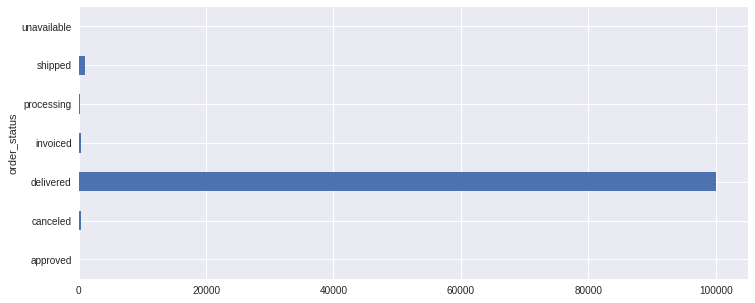

In [ ]:
#null_dates.order_status.unique()
orders_reviews.groupby('order_status').size().plot.barh()


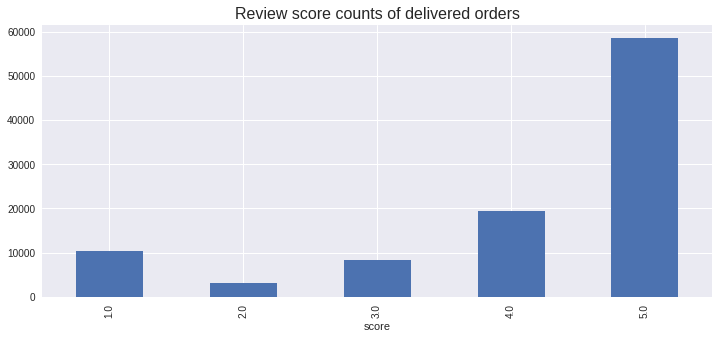

In [ ]:
delivered_orders = orders_reviews[orders_reviews['order_status']=='delivered']
delivered_orders.groupby('score').size().plot.bar()
plt.title('Review score counts of delivered orders', fontsize=16)
plt.show()

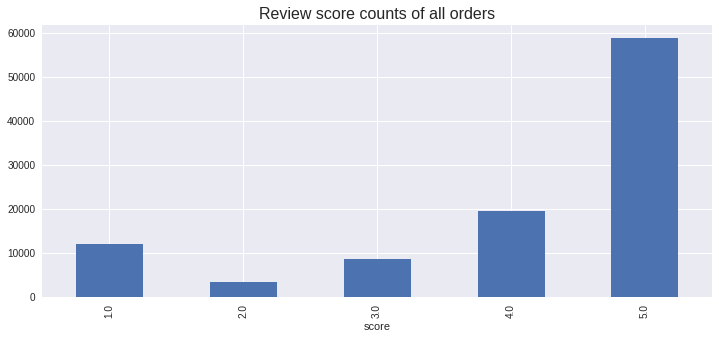

In [ ]:
orders_reviews.groupby('score').size().plot.bar()
plt.title('Review score counts of all orders', fontsize=16)
plt.show()

## Wants to look at delivered orders only because they are the majority and distribution of scores is the same as that of all orders.

In [ ]:
#number of days it takes from time of purchase to delivered, link with review scores
#get rid of all (23) orders with 0000 dates
#delivered_orders[(delivered_orders.order_delivered_carrier_date=='0000-00-00 00:00:00')|(delivered_orders.order_approved_at=='0000-00-00 00:00:00')|(delivered_orders.order_delivered_customer_date=='0000-00-00 00:00:00')]
delivered_orders = delivered_orders[(delivered_orders.order_delivered_carrier_date!='0000-00-00 00:00:00')&(delivered_orders.order_approved_at!='0000-00-00 00:00:00')&(delivered_orders.order_delivered_customer_date!='0000-00-00 00:00:00')]
delivered_orders.shape

(100061, 29)

In [ ]:
#convert object to datetime types
delivered_orders['order_delivered_carrier_date'] = pd.to_datetime(delivered_orders['order_delivered_carrier_date'])
delivered_orders['order_approved_at'] = pd.to_datetime(delivered_orders['order_approved_at'])
delivered_orders['order_delivered_customer_date'] = pd.to_datetime(delivered_orders['order_delivered_customer_date'])
delivered_orders['score'] = delivered_orders['score'].apply(lambda x: int(round(x)))
delivered_orders.info()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<class 'pandas.core.frame.DataFrame'>
Int64Index: 100061 entries, 0 to 103026
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       100061 non-null  object        
 1   product_id                     100061 non-null  object        
 2   seller_id                      100061 non-null  object        
 3   shipping_limit_date            100061 non-null  datetime64[ns]
 4   qty                            100061 non-null  float64       
 5   price                          100061 non-null  float64       
 6   freight_value                  100061 non-null  float64       
 7   customer_id                    100061 non-null  object        
 8   order_status                   100061 non-null  object        
 9   order_purchase_timestamp       100061 non-null  datetime64[ns]
 10  order_approved_at              100061 non-null  datetime64[ns]
 11  

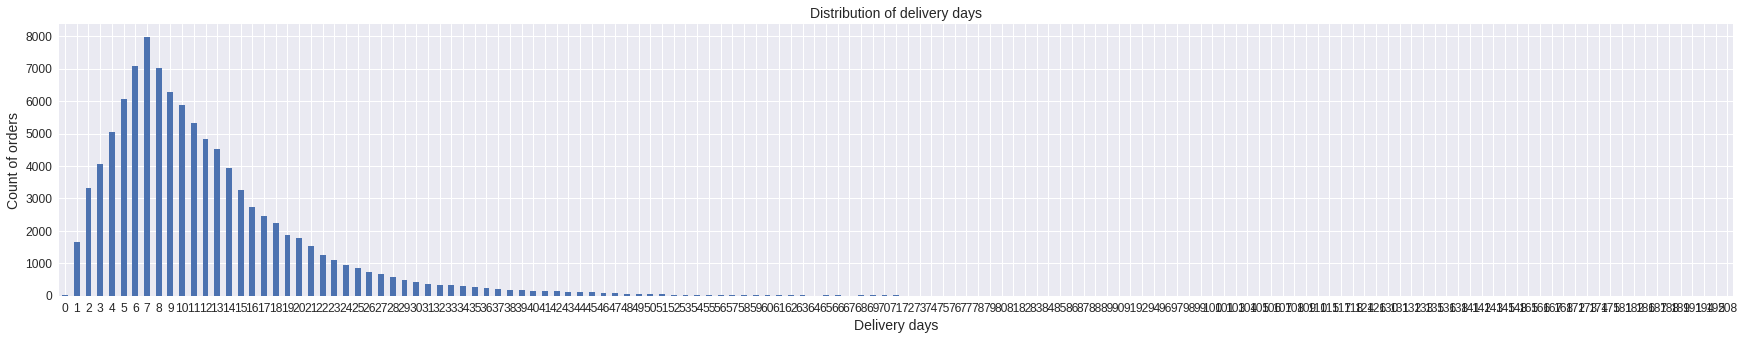

count    100061.000000
mean         11.992774
std           9.440049
min           0.000000
25%           6.000000
50%          10.000000
75%          15.000000
max         208.000000
Name: delivery_days, dtype: float64

In [ ]:
#create new variables: delivery time = delivery date - purchase datefrom datetime import date
delivered_orders['delivery_days'] = (delivered_orders['order_delivered_customer_date']-delivered_orders['order_purchase_timestamp']).dt.days


#mean=23, 75%=28
#distribution of delivery_days is highly right skewed, so only take 50 days and below:
delivered_50 = delivered_orders[delivered_orders['delivery_days']<=40]
delivered_orders.groupby(by='delivery_days').size().plot.bar(figsize=(30,5))
plt.xticks(rotation = 0)
plt.xlabel('Delivery days', fontsize=14)
plt.ylabel('Count of orders', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Distribution of delivery days', fontsize=14)
plt.show()

delivered_orders['delivery_days'].describe()

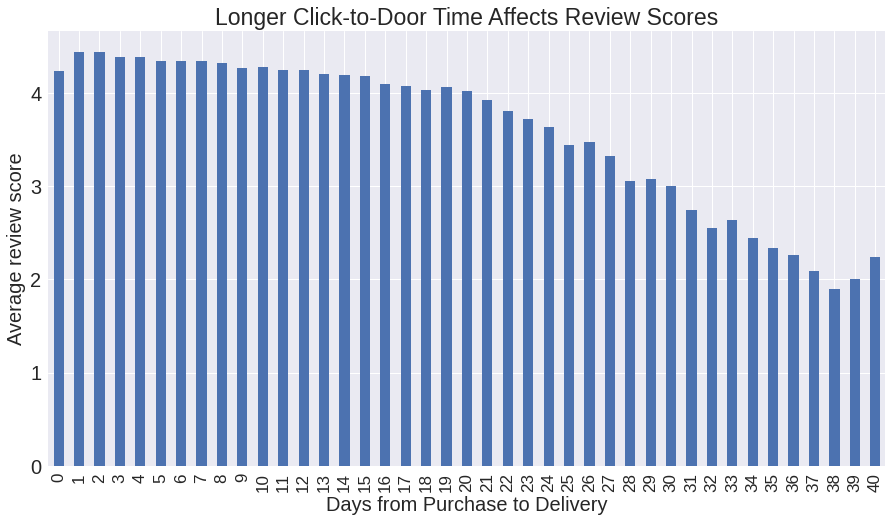

In [ ]:
#The longer
delivered_50.groupby('delivery_days')['score'].mean().plot.bar(figsize=(15,8))
plt.xlabel('Days from Purchase to Delivery', fontsize=20)
plt.ylabel('Average review score', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=20)
plt.title('Longer Click-to-Door Time Affects Review Scores', fontsize=23)
plt.show()


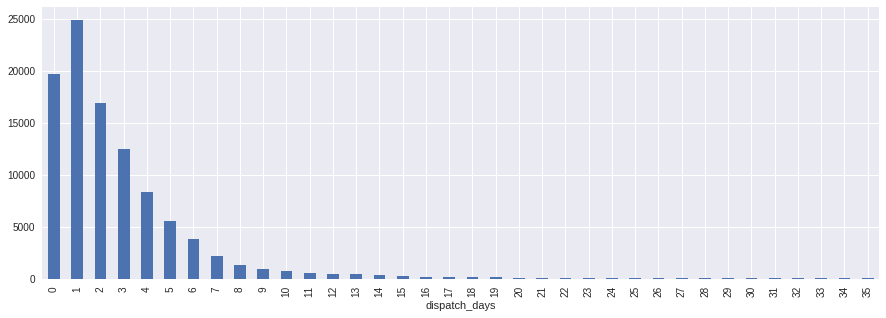

In [ ]:
#dispatch_days = delivered carrier (number days taken by the seller to dispatch the order to the carrier) - order purchase timestamp
delivered_orders['dispatch_days'] = (delivered_orders['order_delivered_carrier_date']-delivered_orders['order_purchase_timestamp']).dt.days
#remove orders where purchase timestamp is LATER than delivered to carrier date
delivered_dispatch = delivered_orders[delivered_orders['dispatch_days']>=0]
delivered_dispatch['dispatch_days'].describe()

delivered_dispatch.groupby(by='dispatch_days').size().plot.bar(figsize=(15,5))
#distribution is highly right skewed. only take till 35 days:
dispatch_35 = delivered_dispatch[delivered_dispatch['dispatch_days']<=35]
dispatch_35.groupby(by='dispatch_days').size().plot.bar(figsize=(15,5))

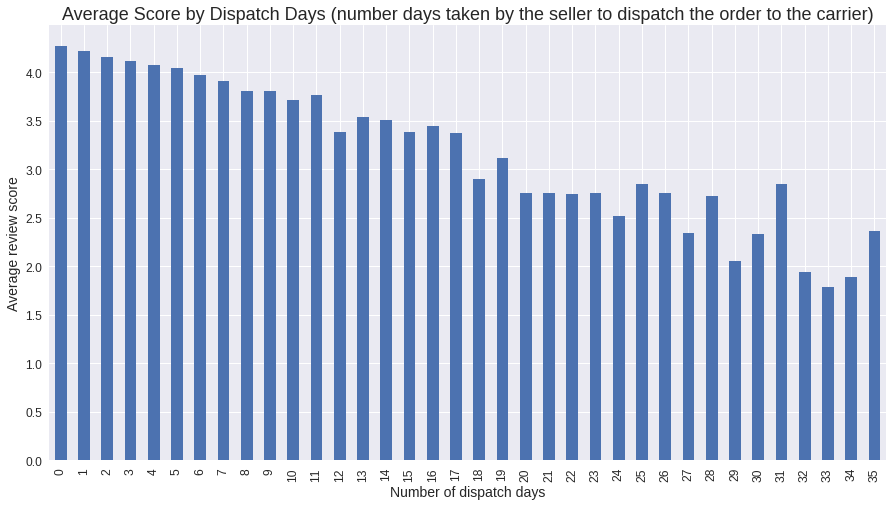

In [ ]:
dispatch_35.groupby('dispatch_days')['score'].mean().plot.bar(figsize=(15,8))
plt.xlabel('Number of dispatch days', fontsize=14)
plt.ylabel('Average review score', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Average Score by Dispatch Days (number days taken by the seller to dispatch the order to the carrier)', fontsize=18)
plt.show()

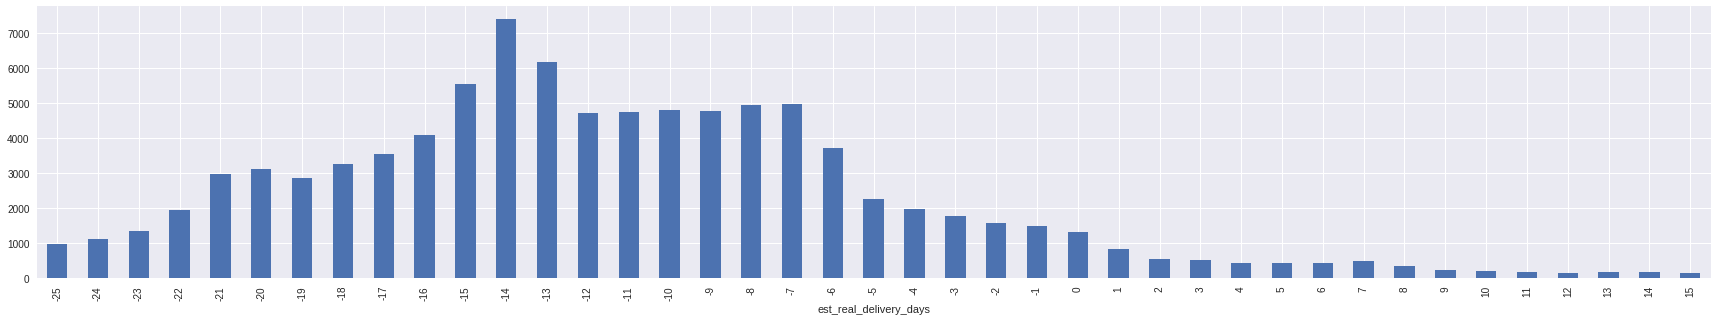

In [ ]:
#actual shipping time (from logistic partner to actual delivery date to customers)
delivered_orders['est_real_delivery_days'] = (delivered_orders['order_delivered_customer_date']-delivered_orders['order_estimated_delivery_date']).dt.days
  #positive means good
delivered_orders['est_real_delivery_days'].describe()

est_real_sub = delivered_orders[(delivered_orders['est_real_delivery_days']>=-25)&(delivered_orders['est_real_delivery_days']<=15)]
est_real_sub.groupby(by='est_real_delivery_days').size().plot.bar(figsize=(30,5))


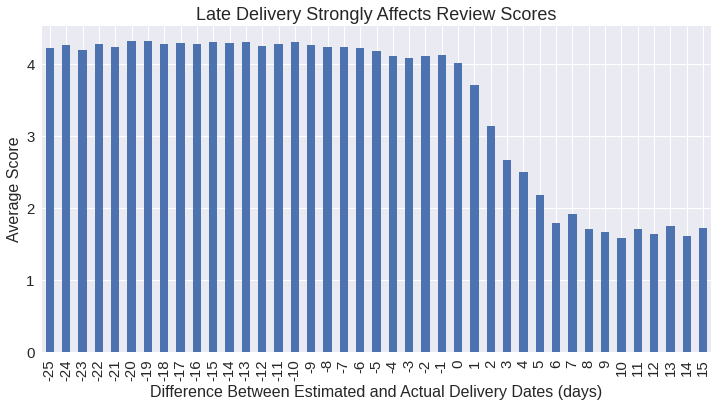

In [ ]:
#LATE DELIVERY REALLY AFFECTS SCORES
est_real_sub.groupby('est_real_delivery_days')['score'].mean().plot.bar(figsize=(12,6))
plt.xlabel('Difference Between Estimated and Actual Delivery Dates (days)', fontsize=16)
plt.ylabel('Average Score', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation = 90)
plt.title('Late Delivery Strongly Affects Review Scores', fontsize=18)
plt.show()



In [ ]:
# who post comments? 5 star raters or 1 star raters?
# moderate raters don't post comments
#potentially from their comments can draw insights on what makes a goood bad orders
#word count of reviews against score => higher score longer reviews

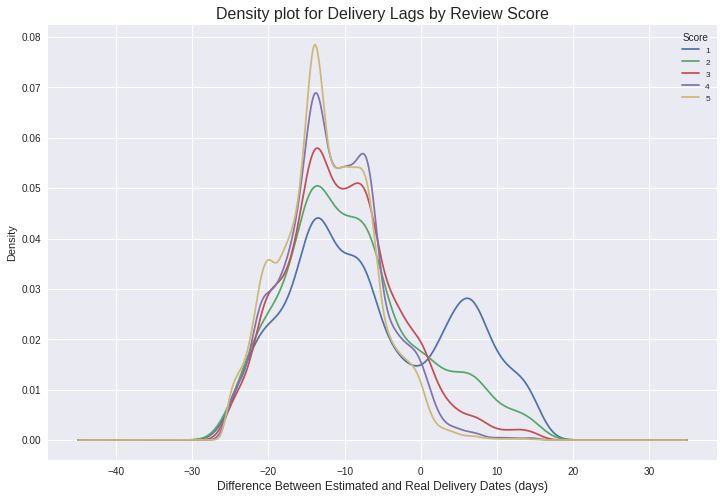

In [ ]:
#The graph above show us the distribution of lags per review given. Noticeably, 1 star reviews have anoticeable bump with late deliveries, strenghtening the reasoning that late deliveries storngly impacts customer review.
est_real_sub.groupby('score')['est_real_delivery_days'].plot.density(legend=True,figsize=(12,8))
plt.title('Density plot for Delivery Lags by Review Score', fontsize=16)
plt.xlabel('Difference Between Estimated and Real Delivery Dates (days)', fontsize=12)
plt.legend(title="Score", fontsize='small', fancybox=True)
plt.show()


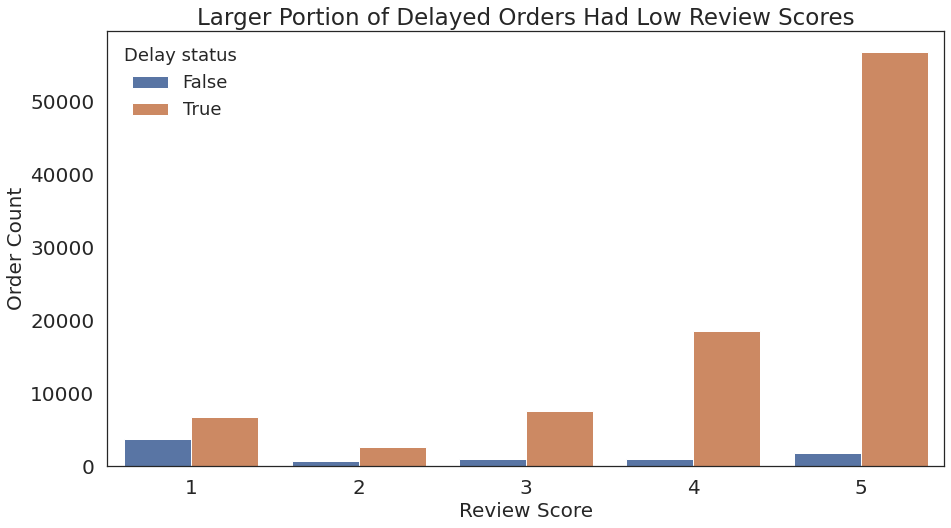

In [ ]:
delivered_orders['is_delay'] = np.where(delivered_orders['est_real_delivery_days']<0, True, False) 
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)})
sns.set_style("white")
sns.countplot(x='score', hue='is_delay', data=delivered_orders)
plt.xlabel('Review Score', fontsize=20)
plt.ylabel('Order Count', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.title('Larger Portion of Delayed Orders Had Low Review Scores', fontsize=23)

plt.legend(title="Delay status",title_fontsize=18, fontsize='18', fancybox=True)


In [ ]:
len(sales)
sales.order_id.nunique()

98666

In [ ]:
# left join sales and payments
sales_payment = pd.merge(sales, payments, on='order_id',how='left')
len(sales_payment)


104746

In [ ]:
sales.order_id.nunique()

98666